In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTENC
import seaborn as sns

In [13]:
df = pd.read_csv(r"../../data/clean/encoded/HealthInspectionsEncoded.csv")
df["failFlag"].value_counts(dropna=False)

failFlag
0    29822
1     2275
Name: count, dtype: int64

## Split into Training, Test and Val 

In [15]:
df["inspection_date"] = pd.to_datetime(
    dict(year=df["insp_year"], month=df["insp_month"], day=df["insp_day"])
)
train_mask = df["inspection_date"] <= "2023-12-31"
val_mask   = (df["inspection_date"] >= "2024-01-01") & (df["inspection_date"] <= "2024-12-31")
test_mask  = df["inspection_date"] >= "2025-01-01"


train_df = df[train_mask].copy()
val_df   = df[val_mask].copy()
test_df  = df[test_mask].copy()
train_df=train_df.drop(columns=["inspection_date"])
val_df=val_df.drop(columns=["inspection_date"])
test_df=test_df.drop(columns=["inspection_date"])
# print(test_df.columns)
train_df.to_csv("../../data/clean/train/HealthInspectionTrain.csv",index=False)
test_df.to_csv("../../data/clean/test/HealthInspectionTest.csv",index=False)
val_df.to_csv("../../data/clean/val/HealthInspectionVal.csv",index=False)
train_df['failFlag'].value_counts(dropna=False)


failFlag
0    15576
1     1333
Name: count, dtype: int64

## Using GAN's

In [16]:
label_col = "failFlag"


X = train_df.drop(columns=[label_col]).values   
y = df[label_col].values.astype(np.float32) 

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

data = torch.tensor(X_scaled, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.float32)

input_dim = data.shape[1]        
latent_dim = 20  #noise



In [17]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh(),           # matches [-1, 1] scaling
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),   
        )

    def forward(self, x):
        return self.model(x)

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

criterion = nn.BCEWithLogitsLoss()         
lr = 2e-4
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [18]:
num_epochs = 300
batch_size = 128

for epoch in range(num_epochs):
    for _ in range(len(data) // batch_size):
       
        optimizer_d.zero_grad()#start with dis

        idx = torch.randint(len(data), (batch_size,))
        real_data = data[idx]
        real_labels = torch.ones(batch_size, 1)

        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z).detach()
        fake_labels = torch.zeros(batch_size, 1)

        out_real = discriminator(real_data)
        out_fake = discriminator(fake_data)

        loss_real = criterion(out_real, real_labels)
        loss_fake = criterion(out_fake, fake_labels)
        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizer_d.step()

        
        optimizer_g.zero_grad() #end with gen
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)
        out_fake = discriminator(fake_data)

        g_loss = criterion(out_fake, real_labels)  
        g_loss.backward()
        optimizer_g.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | D: {d_loss.item():.4f} | G: {g_loss.item():.4f}")


Epoch 50/300 | D: 1.3465 | G: 0.7322
Epoch 100/300 | D: 1.4222 | G: 0.6874
Epoch 150/300 | D: 1.3627 | G: 0.7236
Epoch 200/300 | D: 1.2031 | G: 0.8764
Epoch 250/300 | D: 1.2004 | G: 1.0960
Epoch 300/300 | D: 1.0484 | G: 0.9230


In [19]:
n_synth = 9000
z = torch.randn(n_synth, latent_dim)
synth_scaled = generator(z).detach().cpu().numpy()

synth_X = scaler.inverse_transform(synth_scaled)

synth_df = pd.DataFrame(synth_X, columns=train_df.drop(columns=[label_col]).columns)

synth_df[label_col] = 1.0

synth_df.to_csv("../../data/clean/HealthInspectionGANSynthetic.csv", index=False)

In [20]:
df_syn=pd.read_csv("../../data/clean/HealthInspectionsynthetic.csv")
df_syn["failFlag"].value_counts(dropna=False)

failFlag
1.0    9000
Name: count, dtype: int64

In [ ]:
#there are inspection type feature with continuos number check if this might imporove the model?

# cat_cols = [c for c in synth_df.columns if c.startswith("inspection_type_clean_")]

# def collapse_one_hot(row):
#     vals = row[cat_cols].values.astype(float)
#     idx = np.argmax(vals)             # position of max logit
#     one_hot = np.zeros_like(vals)
#     one_hot[idx] = 1.0
#     row[cat_cols] = one_hot
#     return row

# df_syn = synth_df.apply(collapse_one_hot, axis=1)

In [21]:
df_balanced = pd.concat([train_df, df_syn], ignore_index=True)
df_balanced.to_csv("../../data/clean/train/HealthInspectionGANTrain.csv", index=False)
df_balanced["failFlag"].value_counts(dropna=False)

failFlag
0.0    15576
1.0    10333
Name: count, dtype: int64

## Using SMOTE

In [26]:
df_smote = train_df.copy()
# print(df_smote.columns)

label_col = "failFlag"
df_smote["failFlag"].value_counts(dropna=False)

failFlag
0    15576
1     1333
Name: count, dtype: int64

In [29]:
X = df_smote.drop(columns=[label_col])
y = df_smote[label_col].values


cat_names = (
    ["BusinessName_id", "Address_id", "insp_year", "insp_month", "insp_day", "insp_dow"]
    + [c for c in X.columns if c.startswith("inspection_type_clean_")]
)

cat_indices = [X.columns.get_loc(c) for c in cat_names]

sm = SMOTENC(categorical_features=cat_indices, random_state=42)
X_res, y_res = sm.fit_resample(X.values, y)

# back to DataFrame
train_smote = pd.DataFrame(X_res, columns=X.columns)
train_smote[label_col] = y_res
train_smote.to_csv("../../data/clean/train/HealthInspectionSMOTETrain.csv", index=False)

In [ ]:
train_smote["failFlag"].value_counts(dropna=False)
# changes to be done if the balancing to be done 1:1 or 7:3 based on the  model behaviour

failFlag
0    15576
1    15576
Name: count, dtype: int64

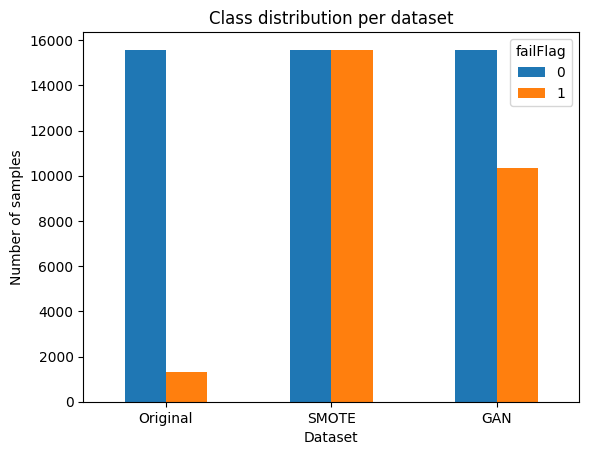

In [ ]:
def class_counts(df, label="failFlag", name="original"):
    c = df[label].value_counts().rename(name)
    return c

counts = pd.concat([
    class_counts(train_df, name="Original"),
    class_counts(train_smote, name="SMOTE"),
    class_counts(df_balanced,   name="GAN"),
], axis=1).T  

counts.plot(kind="bar")
plt.xlabel("Dataset")
plt.ylabel("Number of samples")
plt.title("Class distribution per dataset")
plt.xticks(rotation=0)
plt.show()